In [100]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import random

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

In [102]:
def cov2cor(S: np.ndarray):
    D = np.diag(np.sqrt(np.diag(S)))
    D_inv = np.linalg.inv(D)
    return D_inv @ S @ D_inv

In [103]:
# Self Covariance of AR(1) process
def gen_S_AR1(rho = 0.8,N = 500) -> np.ndarray:
    # generate the covariance matrix of AR(1) process
    S_block = np.zeros(shape=[N, N])
    for j in range(0, N):
        S_block = S_block + np.diag(np.ones(N-j)*(rho**j), -j) + \
        np.diag(np.ones(N-j)*(rho**j), j)
    S = S_block - np.eye(N)
    return S

In [104]:
rng = np.random.RandomState(100)
N = 100
T = 50
alpha = 0.95

In [105]:
S = gen_S_AR1(N = N)
# S = make_sparse_spd_matrix(N, alpha = alpha, random_state = 100)
# print(S[:5, :5])
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
S[:5, :5]

array([[1.    , 0.8   , 0.64  , 0.512 , 0.4096],
       [0.8   , 1.    , 0.8   , 0.64  , 0.512 ],
       [0.64  , 0.8   , 1.    , 0.8   , 0.64  ],
       [0.512 , 0.64  , 0.8   , 1.    , 0.8   ],
       [0.4096, 0.512 , 0.64  , 0.8   , 1.    ]])

In [106]:
c = InfoCorrBand(X)
# c.sample_cov()[:3, :3]
# c.sample_corr()[:3, :3]

d:\BaiduSyncdisk\Project\Comention_simu\infoband\band_info.py:58: UserWarning: L-matrix is missing.
  warnings.warn('L-matrix is missing.')


In [107]:
R = cov2cor(S)
L = abs(R)
c.feed_info(L)
# print(L[:5, :5])

In [108]:
# c.find_biggest_k_for_pd()
# c.plot_k_pd(range(N-50, N+1))

In [109]:
k = c.k_by_cv()
print(k)

6


In [110]:
R_est = c.fit_info_corr_band(k)
S_est = c.fit_info_cov_band(k)

In [111]:
def show_rs(S: np.ndarray, 
            c: InfoCorrBand, m: Covariance, 
            ord = 'fro'):
    # ord: norm type
    R = cov2cor(S)
    print('Correlation itself', LA.norm(R, ord))
    print('Error:')
    print('Sample', LA.norm(c.sample_corr() - R, ord))
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord))
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord))
    print()
    print('Covariance itself', LA.norm(S, ord))
    print('Error:')
    print('Sample', LA.norm(c.sample_cov() - S, ord))
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord))
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord))
    return

In [112]:
m = Covariance(X)

In [116]:
def gen_eta_sequence(N, eta = 0.5, draw_type = 'random', is_random = False, 
                     rand_seed = 100, near_factor = 2) -> np.ndarray:
    '''
    Generate a sequence b, which is a permutation of {1, ..., N}. 
    b satisfies the property: for any 0 < k < N+1, b[0]~b[k-1] include {1, ..., ceil(eta*k)}.  
    
    draw_type : {'random', 'near'}
        Algorithms about how to draw ( {b[0], ..., b[k-1]} - {1, ..., ceil(eta*k)} ). Here '-' is a subtraction between two sets.
    is_random : bool
        If False, we use random_seed as random seed, for repeat running results.
    random_seed : int
    near_factor : float
        Needed only when draw_type = 'near'.
    '''
    if is_random:
        rng = random
    else:
        rng = np.random.RandomState(rand_seed)
        
    b = [1] # Default to keep the diagonal element in covariance estimation.
    b_complement = [i for i in range(2, N + 1)] # b's complement set
    
    for k in range(2, N + 1):
        # consider k-th element
        th = int(np.ceil(eta * k))
        # S^L_k include S^d_{th}
        cnt = sum([1 if num <= th else 0 for num in b])
        if cnt < th:
            for next_id in range(1, th + 1):
                if next_id not in b:
                    b.append(next_id)
                    b_complement.remove(next_id)
                    break
        else:
            # len(b_complement) == N + 1 - k
            if draw_type == 'random':
                j = rng.randint(0, N - k) if N - k > 0 else 0
            elif draw_type == 'near':
                upper = min(int(near_factor * k), N - k)
                j = rng.randint(0, upper) if upper > 0 else 0
            else:
                raise Exception('draw_type, value error')
            next_id = b_complement[j] 
            b.append(next_id)
            b_complement.remove(next_id)
    return np.array(b)

In [117]:
def gen_L(S, eta, verbose = False, draw_type = 'random', is_random = False, 
          rand_seed = 100, near_factor = 2):
    N = S.shape[0]
    new_rowSort = np.zeros((N, N))
    
    R = cov2cor(S)
    L = abs(R)
    rowSort = InfoCorrBand(X = np.eye(N), L = L).rowSort # You can ignore the 'X = np.eye(N)' parameter. I create this temporary object solely to get 'rowSort' matrix.
    
    for i in range(N):
        row = rowSort[i]
        argst = row.argsort()
        b = gen_eta_sequence(N, eta, draw_type, is_random, rand_seed, near_factor)
        for j in range(N):
            new_rowSort[i][argst[j]] = b[j]
    
    L_eta = 1 / new_rowSort
    res = (L_eta, new_rowSort, rowSort)
    return res if verbose else L_eta

In [131]:
L1 = gen_L(S, eta = 0.5, verbose = 0, 
           draw_type = 'near', is_random = 0)
c1 = InfoCorrBand(X = X, L = L1, num_cv = 20)
k1 = c1.k_by_cv()
print(k1)
R_est1 = c1.fit_info_corr_band(k1)
S_est1 = c1.fit_info_cov_band(k1)

13


In [132]:
L2 = gen_L(S, eta = 0.5, verbose = 0, 
           draw_type = 'random', is_random = 0)
c2 = InfoCorrBand(X = X, L = L2, num_cv = 20)
k2 = c2.k_by_cv()
print(k2)
R_est2 = c2.fit_info_corr_band(k2)
S_est2 = c2.fit_info_cov_band(k2)

12


In [135]:
show_rs(S, c, m, 'fro')

Correlation itself 21.111111111111114
Error:
Sample 13.631392272290467
Linear Shrinkage 10.783726393891424
Nonlinear Shrinkage 10.645226862919968

Covariance itself 21.111111111111114
Error:
Sample 16.332019382075213
Linear Shrinkage 11.22974147357275
Nonlinear Shrinkage 11.338422177828734


In [136]:
show_rs(S, c, m, 2)

Correlation itself 8.852795603006218
Error:
Sample 6.814201411242704
Linear Shrinkage 4.43685711015198
Nonlinear Shrinkage 4.2082171685210525

Covariance itself 8.852795603006218
Error:
Sample 9.490711256619804
Linear Shrinkage 4.292072757348996
Nonlinear Shrinkage 4.082295865927169


In [138]:
show_rs(S, c, m, 1)

Correlation itself 8.99987154770766
Error:
Sample 14.735406562129384
Linear Shrinkage 10.554758072074236
Nonlinear Shrinkage 10.829088455935768

Covariance itself 8.99987154770766
Error:
Sample 21.920138319184538
Linear Shrinkage 11.951830954321887
Nonlinear Shrinkage 11.972333459333313


In [159]:
c.rowSort[5][:10]
c1.rowSort[5][:20]
c2.rowSort[5][:10]

array([ 86.,   9.,  74.,   4.,   2.,   1.,   3.,   5.,   8., 100.])

In [139]:
for ord in ['fro', 2, 1]:
    print(ord, 'cor')
    print(LA.norm(R - R_est, ord))
    print(LA.norm(R - R_est1, ord))
    print(LA.norm(R - R_est2, ord))
    print(ord, 'cov')
    print(LA.norm(S - S_est, ord))
    print(LA.norm(S - S_est1, ord))
    print(LA.norm(S - S_est2, ord))

fro cor
11.388159633260239
8.123223489269728
9.173546309218985
fro cov
12.375178539227601
10.002815699337162
10.78395759936061
2 cor
4.760177866619227
2.776528654958325
3.294268904748682
2 cov
4.466169442827456
2.822756641402637
3.121069468383192
1 cor
5.546588062504484
4.528330084047804
5.080527610455801
1 cov
7.695727571019678
6.910985745416026
7.260395112296832


d:\BaiduSyncdisk\Project\Comention_simu\wlpy\gist.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


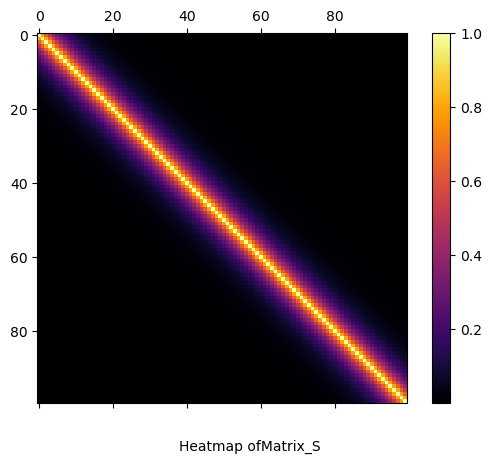

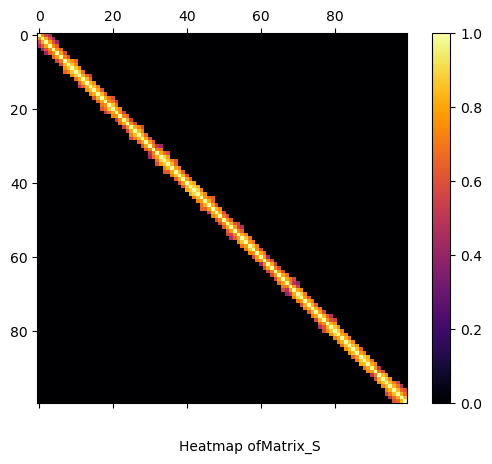

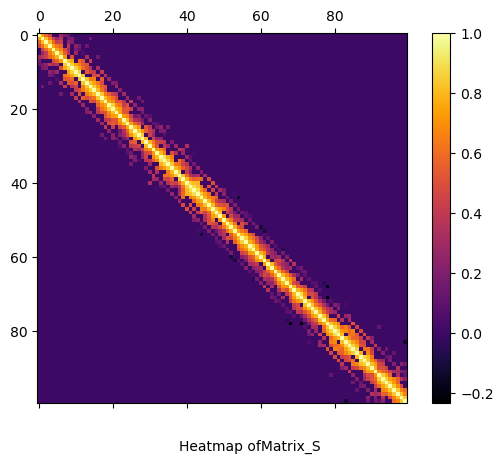

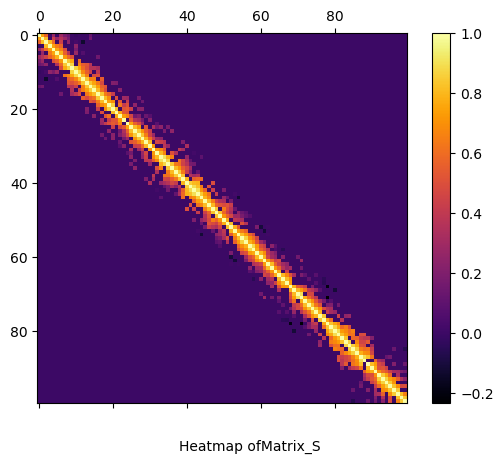

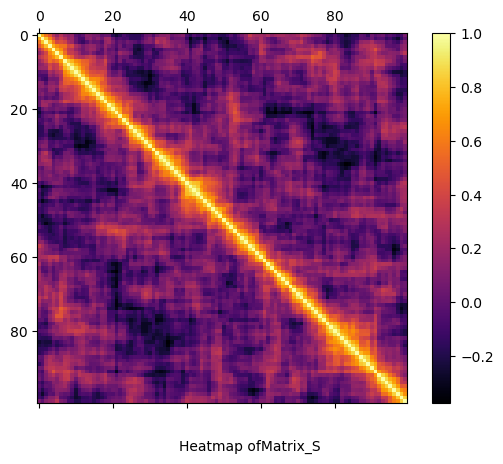

In [145]:
heatmap(R)
heatmap(R_est)
heatmap(R_est1)
heatmap(R_est2)
heatmap(c.sample_corr())